# Draw Hopf fibration using python and POV-Ray

## What is Hopf fibration?

Hopf fibration is a continous map from the 3-sphere $S^3$ onto the 2-sphere $S^2$, where the preimage of each point $p\in S^2$ is a distinct circle called the **fiber** at $p$. The definition of the map is quite simple: identify $\mathbb{R}^4$ with $\mathbb{C}^2$ and $\mathbb{R}^3$ with $\mathbb{C}\times\mathbb{R}$ by writing $(x_1,x_2,x_3,x_4)$ as $(z_1,z_2)=(x_1+ix_2, x_3+ix_4)$ and $(x_1,x_2,x_3)$ as $(z,x)=(x_1+ix_2,x_3)$, thus $S^3$ is identified with the subset of $\mathbb{C}^2$ such that $|z_1|^2+|z_2|^2=1$ and $S^2$ is identified with the subset of $\mathbb{C}\times\mathbb{R}$ such that $|z|^2+x^2=1$, then the Hopf fibration is defined by
$$(z_1,z_2)\to (2z_1\overline{z_2},\, |z_1|^2-|z_2|^2).$$
You can easily verify that if the left hand $(z_1,z_2)$ is on $S^3$, then the right hand must belong to $S^2$.

It's also not hard to write down a parametric representation for the inverse map: a point $p=(x,y,z)\in S^2$ can be parameterized by

\begin{align*}x &= \sin(\phi)\cos(\psi),\\ y &= \sin(\phi)\sin(\psi),\\ z &= \cos(\phi).\end{align*}

where $0 \leq \phi \leq \pi$ and $0 \leq\psi \leq 2\pi$. Then the fiber at $p$ is a circle on $S^3$ parameterized by $0\leq\theta\leq2\pi$:

\begin{align*}x_1&=\cos((\theta+\psi) / 2)\sin(\phi / 2),\\ x_2&=\sin((\theta+\psi) / 2)\sin(\phi / 2),\\x_3&=\cos((\theta-\psi) / 2) \cos(\phi / 2),\\ x_4&=\sin((\theta-\psi) / 2)\cos(\phi / 2).\end{align*}

## How can we visualize it?

To visualize the Hopf fibration we want to choose some points on the 2-sphere $S^2$, draw their fibers and and see what they look like. Since these fibers lie in the 4d space we cannot see them directly, but if we project them to 3d space using the [stereographic projection](https://en.wikipedia.org/wiki/Stereographic_projection) then some remarkable structure appears. The fibers are projected to circles in 3d space (one of which in a line, comes from the fiber through infinity), any two such circles are linked with each other and the line passes through all circles. The 3d space is filled with nested tori made of linking Villarceau circles, each tori is the preimage of a circle of latitude of the 2-sphere. 

So our plan is:

1. Choose some points on the 2-sphere $S^2$.
2. Compute their fibers as circles in $\mathbb{R}^4$.
3. Use stereographic projection to project these fibers to circles in 3d space and draw these circles.

We will use [POV-Ray](www.povray.org) to render our 3d scene here. The computation task is handled in the python part and the rendering task is handled in the POV-Ray part. Certain background knowledge of POV-Ray's syntax is required to understand how the latter works. In summary we simply exports the data of the circles in the format of POV-Ray macros ("macros" are synonymous to "functions" in POV-Ray) and call these macros in the POV-Ray scene file. 

Some global settings:

1. `POV_SCENE_FILE` is the scene file will be called by POV-Ray. It's named `hopf_fibration.pov` in the same directory with this notebook.
2. `POV_DATA_FILE` is the output data file.
3. `POV_EXE` is your POV-Ray executable file. (Don't forget add your POV-Ray executable file to system PATH!)

In [122]:
import subprocess
import numpy as np
from IPython.display import Image

PI = np.pi
POV_SCENE_FILE = "hopf_fibration.pov"
POV_DATA_FILE = "torus-data.inc"
POV_EXE = "pvengine64.exe"
COMMAND = "{} +I{} +W500 +H500 +Q11 +A0.01 +R2".format(POV_EXE, POV_SCENE_FILE)
IMG = POV_SCENE_FILE[:-4] + ".png"

OSC_DATA_FILE = "openscad/torus-data.scad"
OSC_DATA_FILE_HEADER = "use <MCAD/regular_shapes.scad>\n"

## Hopf inverse map and stereographic projection

In [123]:
def hopf_inverse(phi, psi, theta):
    """Inverse map of Hopf fibration. It's a circle in 4d parameterized by theta.
    """
    return np.array([np.cos((theta + psi) / 2) * np.sin(phi / 2),
                     np.sin((theta + psi) / 2) * np.sin(phi / 2),
                     np.cos((theta - psi) / 2) * np.cos(phi / 2),
                     np.sin((theta - psi) / 2) * np.cos(phi / 2)])


def stereo_projection(v):
    """Stereographic projection of a 4d vector with pole at (0, 0, 0, 1).
    """
    v = normalize(v)
    x, y, z, w = v
    return np.array([x, y, z]) / (1 + 1e-8 - w)

## Circle passes through three points

To draw the projected 3d circle of a fiber we choose three points on the fiber and construct the circle from their projected images.

In [124]:
def normalize(v):
    """Normalize a vector.
    """
    return np.array(v) / np.linalg.norm(v)


def norm2(v):
    """Return squared Euclidean norm of a vector.
    """
    return sum([x*x for x in v])


def get_circle(A, B, C):
    """Compute the center, radius and normal of the circle passes
       through 3 given points (A, B, C) in 3d space.
       See "https://en.wikipedia.org/wiki/Circumscribed_circle"
    """
    a = A - C
    b = B - C
    axb = np.cross(a, b)
    center = C + np.cross((norm2(a) * b - norm2(b) * a), axb) / (2 * norm2(axb))
    radius = np.sqrt(norm2(a) * norm2(b) * norm2(a - b) / (4 * norm2(axb)))
    normal = normalize(axb)
    return center, radius, normal

## Convert vector/matrix to POV-Ray format

In [125]:
def pov_vector(v):
    """Convert a vector to POV-Ray format.
    """
    return "<{}>".format(", ".join([str(x) for x in v]))


def pov_matrix(M):
    """Convert a 3x3 matrix to a POV-Ray 3x3 array.
    """
    return "array[3]{{{}}}\n".format(", ".join([pov_vector(v) for v in M]))


# write a test to see if they work as expected:
v = (1, 0, 0)
print("POV-Ray format of {}: {}".format(v, pov_vector(v)))
M = np.eye(3)
print("POV-Ray format of {}: {}".format(M, pov_matrix(M)))

POV-Ray format of (1, 0, 0): <1, 0, 0>
POV-Ray format of [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]: array[3]{<1.0, 0.0, 0.0>, <0.0, 1.0, 0.0>, <0.0, 0.0, 1.0>}



## Orient a circle in 3d space

In POV-Ray CSG 3d circles are represented by the `Torus` object and by POV-Ray's default a `Torus` lies on the $xz$-plane with $y$-axis sticking through its center. So we need an orthogonal matrix to rotate it to a general orientation. 

In [126]:
def transform_matrix(v):
    """Return a 3x3 orthogonal matrix that transforms y-axis (0, 1, 0) to v.
       This matrix is not uniquely determined, we simply choose one with a simple form.
    """
    y = normalize(v)
    a, b, c = y
    if a == 0:
        x = [1, 0, 0]
    else:
        x = normalize([-b, a, 0])
    z = np.cross(x, y)
    return np.array([x, y, z])

## Export data to POV-Ray

Our POV-Ray macro as the interface between python and POV-Ray will be

```
Torus(center, radius, matrix, color)
```

This macro is implemented in the POV-Ray scene file. In python we just pack the data into this format and send them to POV-Ray for rendering.

In [127]:
def export_fiber(phi, psi, color):
    """Export the data of a fiber to POV-Ray format.
    """
    A, B, C = [stereo_projection(hopf_inverse(phi, psi, theta))
               for theta in (0, PI/2, PI)]
    center, radius, normal = get_circle(A, B, C)
    matrix = transform_matrix(normal)
    return "Torus({}, {}, {}, {})\n".format(pov_vector(center),
                                            radius,
                                            pov_matrix(matrix),
                                            pov_vector(color))

# Export data to OpenSCAD

multmatrix(m = [ [cos(angle), -sin(angle), 0, 10],
                 [sin(angle),  cos(angle), 0, 20],
                 [         0,           0, 1, 30],
                 [         0,           0, 0,  1]
              ])

In [128]:
def osc_vector(v):
    """Convert a vector to OpenSCAD format.
    """
    return "[{}]".format(", ".join([str(x) for x in v]))

def osc_matrix(M):
    """Convert a 3x3 matrix to a OpenSCAD 3x3 multimatrix.
    """
    return "multmatrix(m = [{}])".format(", ".join([osc_vector(v) for v in M]))


# write a test to see if they work as expected:
v = (1, 0, 0, 0)
print("OpenSCAD format of {}: {}".format(v, osc_vector(v)))
M = np.eye(4)
print("OpenSCAD format of {}: {}".format(M, osc_matrix(M)))

OpenSCAD format of (1, 0, 0, 0): [1, 0, 0, 0]
OpenSCAD format of [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]: multmatrix(m = [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])


In [129]:
def export_fiber_osc(phi, psi, color, fattness = 0.5, scale = 10):
    """Export the data of a fiber to OpenSCAD format.
    """
    A, B, C = [stereo_projection(hopf_inverse(phi, psi, theta))
               for theta in (0, PI/2, PI)]
    center, radius, normal = get_circle(A, B, C)
    matrix = transform_matrix(normal)
    matrix = np.append(matrix,[[0],[0],[0]], axis = 1)
    matrix = np.append(matrix,[[0],[0],[0],[1]])
    return "{}{{ color(c = {}) translate({}) torus2({}, {});}};\n".format(osc_matrix(matrix), osc_vector(color), osc_vector(center),scale*radius, fattness)

In [130]:
A, B, C = [stereo_projection(hopf_inverse(PI, PI, theta))
               for theta in (0, PI/2, PI)]
center, radius, normal = get_circle(A, B, C)
matrix = transform_matrix(normal)
print(matrix, type(matrix))
matrix = np.append(matrix,[[0],[0],[0]], axis = 1)
matrix = np.append(matrix,[[0],[0],[0],[1]])
print(matrix, type(matrix))

[[ 1.21494133e-16  1.00000000e+00  0.00000000e+00]
 [ 6.12323400e-17 -7.43937006e-33  1.00000000e+00]
 [ 1.00000000e+00 -1.21494133e-16 -6.12323400e-17]] <class 'numpy.ndarray'>
[ 1.21494133e-16  1.00000000e+00  0.00000000e+00  0.00000000e+00
  6.12323400e-17 -7.43937006e-33  1.00000000e+00  0.00000000e+00
  1.00000000e+00 -1.21494133e-16 -6.12323400e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00] <class 'numpy.ndarray'>


In [131]:
def draw_flower_osc(petals=3, fattness=0.5, amp=-PI/7, lat=PI/2, num_fibers=40):
    """parameters
       ----------
       petals: controls the number of petals.
       fattness: controls the fattness of the petals.
       amp: controls the amplitude of the polar angle range.
       lat: controls latitude of the flower.
    """
    with open(OSC_DATA_FILE, "w") as f:
        f.write(OSC_DATA_FILE_HEADER)
        for t in np.linspace(0, 1, num_fibers):
            phi = amp * np.sin(petals * 2 * PI * t) + lat
            psi = PI * 2 * t + fattness * np.cos(petals * 2 * PI * t)
            color = np.random.random(3)
            f.write(export_fiber_osc(phi, psi, color))

In [132]:
draw_flower_osc()

TypeError: 'numpy.float64' object is not iterable

## Let's draw some examples!

Finally we can draw a set of random points on $S^2$ and see how their fibers look like in 3d space: 

In [133]:
def draw_random_fibers(N):
    """Draw fibers of some random points on the 2-sphere.
       `N` is the number of fibers.
    """
    phi_range = (PI / 6, PI * 4 / 5)
    psi_range = (0, 2 * PI)
    phi_list = np.random.random(N) * (phi_range[1] - phi_range[0]) + phi_range[0]
    psi_list = np.random.random(N) * (psi_range[1] - psi_range[0]) + psi_range[0]
    with open(POV_DATA_FILE, "w") as f:
        for phi, psi in zip(phi_list, psi_list):
            color = np.random.random(3)
            f.write(export_fiber(phi, psi, color))
    subprocess.call(COMMAND, shell=True)

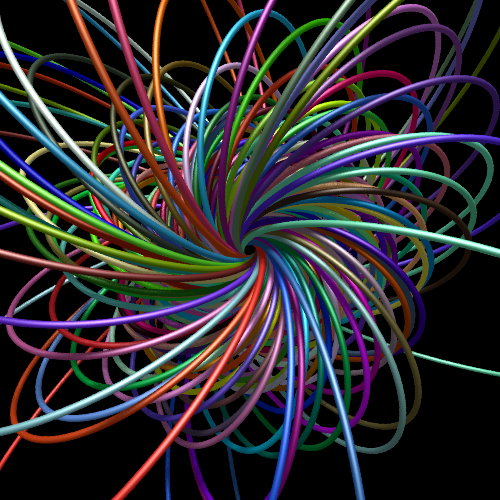

In [134]:
draw_random_fibers(N=200)
Image(IMG)

And also a flower pattern:

In [141]:
def draw_flower(petals=7, fattness=0.5, amp=-PI/7, lat=PI/2, num_fibers=40):
    """parameters
       ----------
       petals: controls the number of petals.
       fattness: controls the fattness of the petals.
       amp: controls the amplitude of the polar angle range.
       lat: controls latitude of the flower.
    """
    with open(POV_DATA_FILE, "w") as f:
        for t in np.linspace(0, 1, num_fibers):
            phi = amp * np.sin(petals * 2 * PI * t) + lat
            psi = PI * 2 * t + fattness * np.cos(petals * 2 * PI * t)
            color = np.random.random(3)
            f.write(export_fiber(phi, psi, color))
    subprocess.call(COMMAND, shell=True)

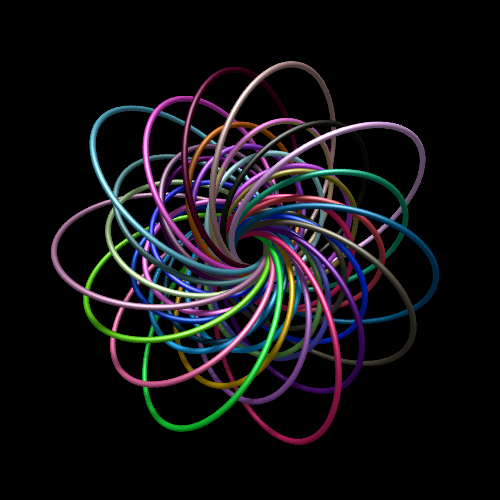

In [142]:
draw_flower()
Image(IMG)